**Import Library dan Packages yang Digunakan**

In [ ]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

**DATA UNDERSTANDING**

**Load Data**

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dataset ini diambil dari platform Kaggle: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset

In [ ]:
books = pd.read_csv('/content/drive/MyDrive/Dicoding/Submission_Recommendation System/Books.csv')
ratings = pd.read_csv('/content/drive/MyDrive/Dicoding/Submission_Recommendation System/Ratings.csv')
users = pd.read_csv('/content/drive/MyDrive/Dicoding/Submission_Recommendation System/Users.csv')

<ipython-input-3-2b25973e98c7>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('/content/drive/MyDrive/Dicoding/Submission_Recommendation System/Books.csv')


In [ ]:
print('Jumlah data "books": ', len(books.ISBN.unique()))
print('Jumlah data "ratings": ', len(ratings['User-ID'].unique()))
print('Jumlah data "users": ', len(users['User-ID'].unique()))

Jumlah data "books":  271360
Jumlah data "ratings":  105283
Jumlah data "users":  278858


**Menampilkan Informasi Data "Books"**

In [ ]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [ ]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


Menunjukkan gambaran umum terkait struktur data **"Books"**. Data ini memiliki 271.360 baris data dan 8 kolom.

In [ ]:
# Memeriksa missing value
books.isnull().sum()

,0
ISBN,0
Book-Title,0
Book-Author,2
Year-Of-Publication,0
Publisher,2
Image-URL-S,0
Image-URL-M,0
Image-URL-L,3


Terdapat *missing value* pada kolom **"Book-Author", "Publisher"**, dan **"Image-URL-L"**.

**Menampilkan Informasi Data "Ratings"**

In [ ]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


Menunjukkan gambaran umum terkait struktur data **"Ratings"**. Data ini memiliki 1.149.780  baris data dan 3 kolom.

In [ ]:
ratings.isnull().sum()

,0
User-ID,0
ISBN,0
Book-Rating,0


Mengecek jumlah *missing value* dari data **"Ratings"**. Dari output diatas, tidak ada *missing value* yang berarti data tersebut bersih.

**Menampilkan Informasi Data "Users"**

In [ ]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


Menunjukkan gambaran umum terkait struktur data **"Users"**. Data ini memiliki 278.858  baris data dan 3 kolom.

In [ ]:
users.isnull().sum()

,0
User-ID,0
Location,0
Age,110762


Data **"Users"** memiliki *missing value* pada kolom **"Age"** sebanyak 110.762 data.

**Visualization Data**

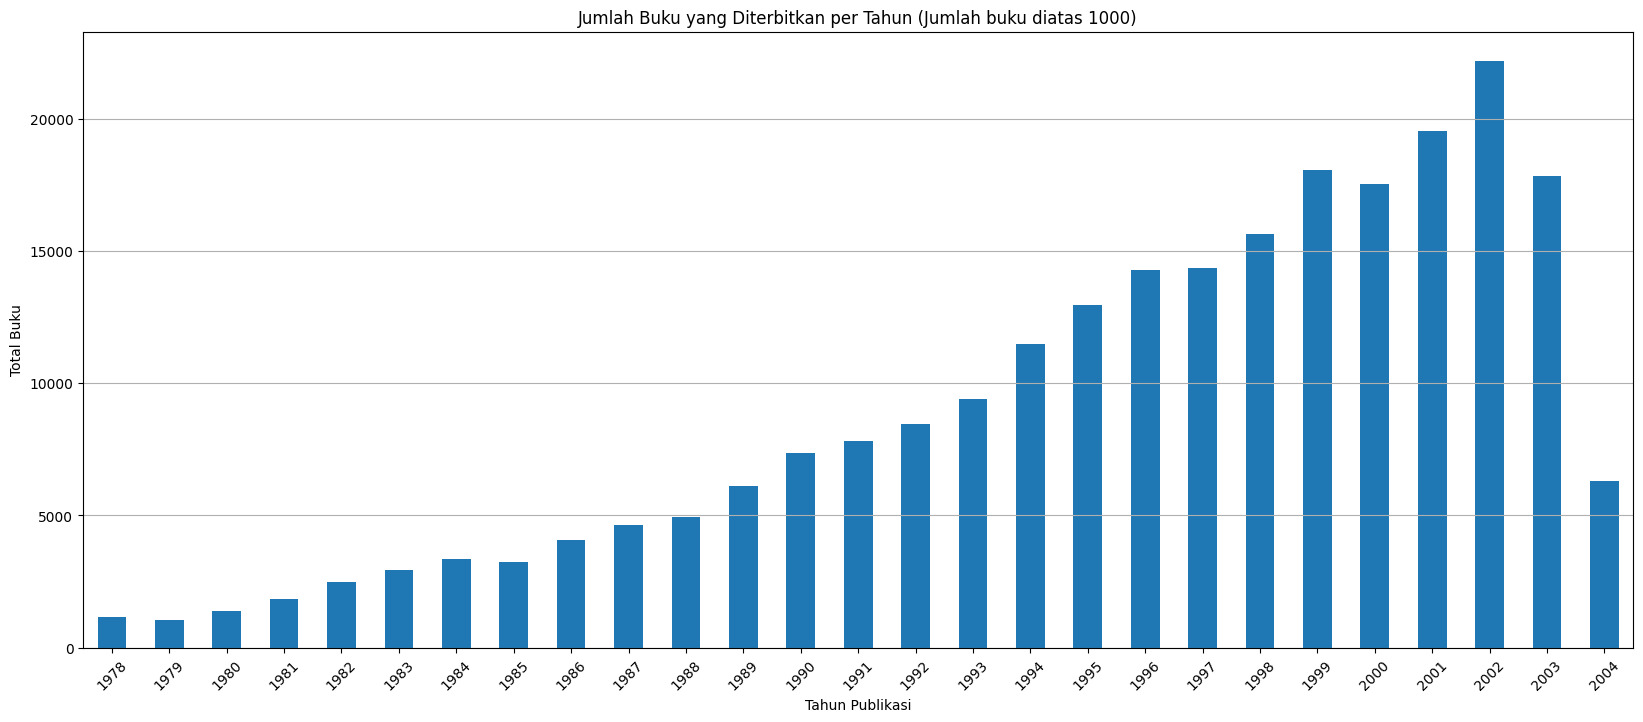

In [ ]:
sampled_data['Year-Of-Publication'] = pd.to_numeric(sampled_data['Year-Of-Publication'], errors='coerce').fillna(0)

# Set Data type of Year-Of-Publication to Integer
sampled_data['Year-Of-Publication'] = sampled_data['Year-Of-Publication'].astype(int)

# Filter valid publication years (greater than 0)
valid_years = sampled_data[sampled_data['Year-Of-Publication'] > 0]['Year-Of-Publication']

# Count total books per year
books_per_year_filtered = valid_years.value_counts()

# Filter the number of books published above 1000
books_per_year_filtered = books_per_year_filtered[books_per_year_filtered > 1000]

# Sort data based on year of publication from the previous year
books_per_year_filtered = books_per_year_filtered.sort_index(ascending=True)

# Bar plot
plt.figure(figsize=(20, 8))
books_per_year_filtered.plot(kind='bar')
plt.title('Jumlah Buku yang Diterbitkan per Tahun (Jumlah buku diatas 1000)')
plt.xlabel('Tahun Publikasi')
plt.ylabel('Total Buku')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

Visualisasi diatas menunjukkan jumlah buku yang diterbitkan setiap tahunnya dari 1978-2004. Buku paling banyak diterbitkan berada pada tahun **2002**, dan paling sedikit berada pada tahun **1978**.

**DATA PREPARATION**

**Menggabungkan Data "Books", "Ratings", dan "Users"**

In [ ]:
merge_data = pd.merge(ratings, books, on='ISBN')
data = pd.merge(merge_data, users, on='User-ID')

data.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Location,Age
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,"tyler, texas, usa",NaN
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001,Heinle,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...,"seattle, washington, usa",NaN
2,276727,0446520802,0,The Notebook,Nicholas Sparks,1996,Warner Books,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,"h, new south wales, australia",16.0
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...,"rijeka, n/a, croatia",16.0
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,"rijeka, n/a, croatia",16.0


Karena data mentah terbagi menjadi 3 data yang berbeda, maka perlu menggabungkan semua data menjadi satu terlebih dahulu. Data "Ratings" dan "Books" digabungkan berdasarkan nilai **ISBN**. Kemudian, data gabungan dari ratings dan books digabungkan lagi dengan data users berdasarkan nilai **"User-ID"**. Setelah semua data sudah menjadi satu, hasilnya terlihat seperti diatas.

**Mengurangi jumlah data karena device tidak kuat melakukan running**

In [ ]:
# Mengambil sampel acak sebanyak 500.000 baris
sampled_data = data.sample(n=250000, random_state=42)

# Reset index agar indeks urut kembali setelah pengambilan sampel
sampled_data = sampled_data.reset_index(drop=True)

Karena banyaknya jumlah data, device tidak kuat untuk melakukan running. Oleh karena itu, dilakukan pengurangan jumlah data dan hanya menggambil 250.000 data saja.Pengambilan data tersebut dilakukan secara random.

**Menghapus kolom "Image-URL-L", "Image-URL-m" dan "Location" karena tidak digunakan dalam pembuatan sistem rekomendasi.**

In [ ]:
sampled_data.drop(columns=['Image-URL-L', 'Image-URL-M', 'Location'], inplace=True)

Dalam pembuatan sistem rekomendasi buku terdapat 3 kolom yang tidak akan digunakan, yaitu **"Image-URL-L", "Image-URL-m" dan "Location"**. Maka dari itu, kolomnya dihapus.

**Mengatasi Missing Value**

Mengisi nilai missing value pada data **"Books"**. Mengisi kolom "Book Author" dan "Publisher" dengan nilai modus

In [ ]:
sampled_data['Book-Author'].fillna(sampled_data['Book-Author'].mode()[0], inplace=True)
sampled_data['Publisher'].fillna(sampled_data['Publisher'].mode()[0], inplace=True)

<ipython-input-17-8738c8513151>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sampled_data['Book-Author'].fillna(sampled_data['Book-Author'].mode()[0], inplace=True)
<ipython-input-17-8738c8513151>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col]

**Nilai modus** adalah nilai yang paling sering muncul pada data.

Mengisi nilai missing value pada kolom **"Age"** dengan nilai median

In [ ]:
sampled_data['Age'].fillna(sampled_data['Age'].median(), inplace=True)

<ipython-input-19-fd43f18c8c50>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sampled_data['Age'].fillna(sampled_data['Age'].median(), inplace=True)


**Nilai median** adalah angka tengah dari kumpulan data yang telah diurutkan.

In [ ]:
sampled_data.isnull().sum()
sampled_data.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Age
0,208390,0142000205,5,Icy Sparks,Gwyn Hyman Rubio,2001,Penguin Books,http://images.amazon.com/images/P/0142000205.0...,32.0
1,123625,0590568809,7,"The Beast from the East (Goosebumps, No 43)",R. L. Stine,1996,Scholastic,http://images.amazon.com/images/P/0590568809.0...,22.0
2,16943,0552997544,0,Cloud Music,Karen Hayes,1997,Black Swan,http://images.amazon.com/images/P/0552997544.0...,35.0
3,144255,0385490992,4,The Street Lawyer,John Grisham,1998,Doubleday Books,http://images.amazon.com/images/P/0385490992.0...,35.0
4,11676,0671776800,10,Paradise,Judith McNaught,1992,Pocket,http://images.amazon.com/images/P/0671776800.0...,35.0


**Mengubah tipe data kolom "Age" menjadi numerik**

In [ ]:
sampled_data['Age'] = pd.to_numeric(sampled_data['Age'], errors='coerce').fillna(0).astype(int)

Proses diatas mengkonversi data dalam kolom **"Age"** menjadi tipe data int dan mengganti nilai non-numerik menjadi 0.

In [ ]:
sampled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   User-ID              250000 non-null  int64 
 1   ISBN                 250000 non-null  object
 2   Book-Rating          250000 non-null  int64 
 3   Book-Title           250000 non-null  object
 4   Book-Author          250000 non-null  object
 5   Year-Of-Publication  250000 non-null  int64 
 6   Publisher            250000 non-null  object
 7   Image-URL-S          250000 non-null  object
 8   Age                  250000 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 17.2+ MB


Dari beberapa proses sebelumnya, terlihat bahwa semuanya telah berhasil dilakukan. Data keseluruhan berjumlah 250.000 baris dan memiliki 9 kolom data. Data ini memiliki 2 tipe data, yaitu object dan int.

Menghapus data dari kolom **"Book-Rating"** yang bernilai "0"

In [ ]:
sampled_data = sampled_data[sampled_data["Book-Rating"] != 0]

In [ ]:
# Memeriksa rating buku yang bernilai "0"
zero_rating_books_df = sampled_data[sampled_data["Book-Rating"] == 0]
zero_rating_books_df

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Age


Buku yang memiliki rating 0 dihapus agar spesifikasi data yang digunakan semakin jelas, semua buku memiliki rating yang jelas.

In [ ]:
sampled_data.describe()

,User-ID,Book-Rating,Year-Of-Publication,Age
count,92750.000000,92750.000000,92750.000000,92750.000000
mean,135873.401919,7.634210,1965.332571,36.305348
std,80433.209999,1.831519,244.555057,11.602919
min,8.000000,1.000000,0.000000,0.000000
25%,67079.000000,7.000000,1992.000000,31.000000
50%,133766.500000,8.000000,1998.000000,35.000000
75%,205943.000000,9.000000,2001.000000,40.000000
max,278854.000000,10.000000,2037.000000,244.000000


Tahun publikasi dan umur minimum dan maksimal tidak masuk akal.

**Mengatasi Outlier untuk data "Age" dan "Year-of-Publication**

In [ ]:
# Age
age_q1 = sampled_data['Age'].quantile(0.25)
age_q3 = sampled_data['Age'].quantile(0.75)
age_iqr = age_q3 - age_q1
age_lower_bound = age_q1 - 1.5 * age_iqr
age_upper_bound = age_q3 + 1.5 * age_iqr
sampled_data = sampled_data[(sampled_data['Age'] >= age_lower_bound) & (sampled_data['Age'] <= age_upper_bound)] # Menghapus baris yang memiliki nilai 'Age' di luar rentang [age_lower_bound, age_upper_bound]

# Year-Of-Publication
year_q1 = sampled_data['Year-Of-Publication'].quantile(0.25)
year_q3 = sampled_data['Year-Of-Publication'].quantile(0.75)
year_iqr = year_q3 - year_q1
year_lower_bound = year_q1 - 1.5 * year_iqr
year_upper_bound = year_q3 + 1.5 * year_iqr
sampled_data = sampled_data[(sampled_data['Year-Of-Publication'] >= year_lower_bound) & (sampled_data['Year-Of-Publication'] <= year_upper_bound)] # Menghapus baris yang memiliki nilai 'Tahun Terbit' di luar rentang [tahun_terbatas_bawah, tahun_terbatas_atas]

sampled_data.describe()

,User-ID,Book-Rating,Year-Of-Publication,Age
count,80137.000000,80137.000000,80137.000000,80137.000000
mean,135290.219399,7.613063,1996.480565,35.006451
std,80412.474421,1.832128,5.675598,7.547900
min,8.000000,1.000000,1979.000000,18.000000
25%,66772.000000,7.000000,1993.000000,31.000000
50%,133225.000000,8.000000,1998.000000,35.000000
75%,204964.000000,9.000000,2001.000000,37.000000
max,278854.000000,10.000000,2006.000000,53.000000


Statistik deskriptif dari data integer terlihat seperti diatas. Tahun publikasi dan umur sudah memiliki nilai yang logis.

In [ ]:
pd.set_option('display.max_colwidth', None)

title_sample = sampled_data[['ISBN', 'Book-Title', 'Book-Author']].sample(20)

print(title_sample.to_string(index=False))

      ISBN                                                                           Book-Title          Book-Author
0743204077                                                                         Soul Stories           Gary Zukav
0812552741                                                        Echoes In Time (Time Traders)         Andre Norton
0553582658                                                                         Summer Light          Luanne Rice
0004704746         Complete Works of William Shakespeare: The Alexander Text (Collins Classics)  William Shakespeare
0812575717                                                                       Ender's Shadow     Orson Scott Card
073739983X                                                                     Draw the Titanic       Andrew Staiano
0316602051                                                                           The Jester      James Patterson
014302812X The Merlion and the Hibiscus: Contemporary Short Stor

Menampilkan 20 sampel baris data yang terdiri dari kolom **"ISBN", "Book-Title"**, dan **"Book-Author"**.

In [ ]:
data_fix = sampled_data

**Mendefinisikan Genre Tiap Judul Buku**

Sistem rekomendasi buku ini akan dirancang berdasarkan genre buku tersebut.

In [ ]:
genres = ['Fiction', 'Novel', 'Adventure', 'Romance', 'History', 'Thriller', 'Horror', 'Biography', 'Fantasy', 'Other']

Mendefinisikan genre-genre buku yang akan digunakan sebagai label untuk memprediksi genre berdasarkan judul.

In [ ]:
# Model Word2Vec
sentences = [title.split() for title in data_fix['Book-Title']]

# Latih model Word2Vec
model = Word2Vec(sentences, vector_size=500, window=5, min_count=5, sg=2)

Membuat list sentences, yang merupakan daftar kata dari setiap judul buku di kolom **"Book-Title"**. Setiap judul buku dipisahkan menjadi kata-kata.

In [ ]:
# Labelling

import re

def clean_text(text):
    # Menghilangkan karakter khusus dan angka
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Mengubah teks menjadi huruf kecil
    text = text.lower()
    return text

# Membuat fungsi untuk memprediksi genre dari judul buku
def predict_genre(book_title):
    clean_title = clean_text(book_title)
    title_words = clean_title.split()

    # Mengecek apakah title_words kosong
    if not title_words:
        return 'Other'

    # Memfilter kata-kata
    title_words = [word for word in title_words if word in model.wv]

    if not title_words:
        return 'Other'

    # Menghitung rata-rata vektor kata untuk judul buku
    title_vector = sum([model.wv[word] for word in title_words]) / len(title_words)

    # Menemukan genre yang paling mirip berdasarkan cosine similarity
    most_similar_genre = None
    max_similarity = -1
    for genre in genres:
        genre_vector = model.wv[genre]
        similarity = cosine_similarity([title_vector], [genre_vector])[0][0]
        if similarity > max_similarity:
            max_similarity = similarity
            most_similar_genre = genre

    return most_similar_genre

Secara keseluruhan, proses diatas bertujuan untuk menentukan genre buku secara otomatis berdasarkan judulnya. Model ***Word2Vec*** digunakan untuk menghasilkan representasi vektor kata, dan fungsi predict_genre mengidentifikasi genre dengan kesamaan tertinggi menggunakan metode **cosine similarity**.

In [ ]:
# Test
book_title_to_predict = "All Souls (Javier Marias)"
predicted_genre = predict_genre(book_title_to_predict)

print(f"The predicted genre for '{book_title_to_predict}' is {predicted_genre}.")

The predicted genre for 'All Souls (Javier Marias)' is Horror.


Mencoba memprediksi genre buku berdasarkan judul buku yang dimasukkan.

In [ ]:
!pip install swifter
import swifter

In [ ]:
data_fix['Genre'] = data_fix['Book-Title'].swifter.apply(predict_genre)

Pandas Apply:   0%|          | 0/80137 [00:00<?, ?it/s]

Menambahkan kolom **"Genre"** ke dalam keseluruhan data, dimana data genre tersebut adalah hasil prediksi dari fungsi predict_genre sebelumnya.

**Menghapus Duplikasi Judul Buku**

Dalam membuat sistem rekomendasi, penting untuk memastikan bahwa sebuah data hanya terdapat satu, tidak ada duplikasi lain. Oleh karena itu, dilakukan proses untuk menghapus duplikasi dari data **"Book-Title"**.

In [ ]:
data_fix = data_fix.drop_duplicates(subset='Book-Title')

In [ ]:
data_fix = data_fix.reset_index(drop=True)

In [ ]:
data_fix.sample(10)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Age,Genre
14601,69697,0373271697,9,"Marrying Mccabe (Intimate Moments, 1099)",Fiona Brand,2001,Silhouette,http://images.amazon.com/images/P/0373271697.01.THUMBZZZ.jpg,24,Other
7619,164828,0451406176,9,The Duke,Catherine Coulter,1995,Topaz,http://images.amazon.com/images/P/0451406176.01.THUMBZZZ.jpg,35,History
7492,218608,0786885424,10,The Rolling Stone Book of the Beats : The Beat Generation and American Culture,Holly George-Warren,2000,Hyperion,http://images.amazon.com/images/P/0786885424.01.THUMBZZZ.jpg,31,History
12756,187202,1552128202,9,Memoirs Two: Sea Fever,Harry Furniss,2001,Not Avail,http://images.amazon.com/images/P/1552128202.01.THUMBZZZ.jpg,35,Other
560,98322,0373261047,9,Real Murders,Richard Harris,1992,Worldwide Library,http://images.amazon.com/images/P/0373261047.01.THUMBZZZ.jpg,40,Other
23169,52199,0345378881,10,The Reckoning,SHARON KAY PENMAN,1992,Ballantine Books,http://images.amazon.com/images/P/0345378881.01.THUMBZZZ.jpg,47,History
14704,76499,0553562835,10,Sam Walton: Made in America : My Story,Sam Walton,1993,Bantam Books,http://images.amazon.com/images/P/0553562835.01.THUMBZZZ.jpg,35,Horror
28923,102154,0761511091,9,Might and Magic VI: The Mandate of Heaven : Prima's Official Strategy Guide,Ted Chapman,1998,Prima Lifestyles,http://images.amazon.com/images/P/0761511091.01.THUMBZZZ.jpg,35,History
39481,33826,0877736391,7,Indian Herbalogy of North America (Healing Arts),ALMA R. HUTCHENS,1991,Shambhala,http://images.amazon.com/images/P/0877736391.01.THUMBZZZ.jpg,35,History
42854,190925,1583143998,7,Come Fall (Arabesque),Marcia King-Gamble,2003,Arabesque,http://images.amazon.com/images/P/1583143998.01.THUMBZZZ.jpg,51,Other


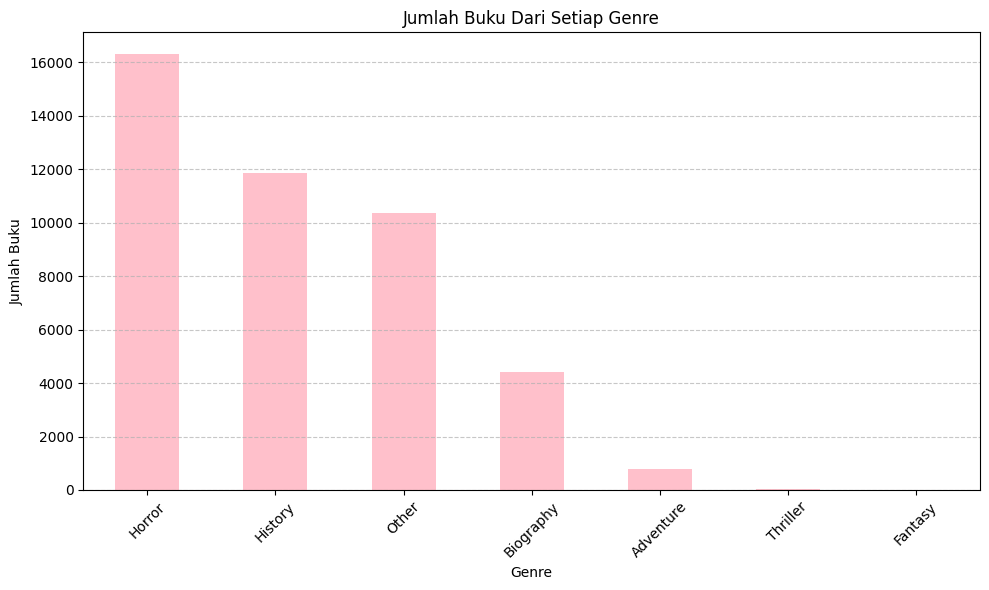

In [ ]:
genre_counts = data_fix['Genre'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', color='pink')
plt.title('Jumlah Buku Dari Setiap Genre')
plt.xlabel('Genre')
plt.ylabel('Jumlah Buku')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Visualisasi diatas digunakan untuk menampilkan banyaknya buku per genre. Seperti yang terlihat, buku paling banyak bergenre **horror**, dan yang paling sedikit bergenre **fantasy**.

**Mengkonversi Kolom "Book-Title" menjadi TF-IDF**

In [ ]:
# Inisialisasi TfidfVectorizer
tfidf = TfidfVectorizer()

# Mengubah kolom 'Book-Title' menjadi vektor nu merik menggunakan TF-IDF
tfidf_matrix = tfidf.fit_transform(data_fix['Book-Title'])

# Menampilkan dimensi matriks TF-IDF yang dihasilkan (baris x kolom)
tfidf_matrix.shape

(43758, 29520)

Menggunakan teknik **TF-IDF (Term Frequency-Inverse Document Frequency)**, membuat teks dalam kolom "Book-Title" diubah menjadi representasi vektor yang akan digunakan untuk menghitung kesamaan antar buku.

In [ ]:
tfidf_matrix.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

**MODELLING AND RESULT**

**Menghitung Cosine Similarity**

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Menghitung cosine similarity antara vektor TF-IDF untuk menemukan kesamaan antar buku
cosine_sim = cosine_similarity(tfidf_matrix)

# Menampilkan dimensi matriks cosine similarity yang dihasilkan
cosine_sim

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.03454553, ..., 0.        , 0.04356505,
        0.        ],
       [0.        , 0.03454553, 1.        , ..., 0.        , 0.03242811,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.04356505, 0.03242811, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

Setelah vektor TF-IDF terbentuk, dilakukan perhitungan kesamaan antar judul buku menggunakan metode **cosine similarity**.

In [ ]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa judul buku
cosine_sim_df = pd.DataFrame(cosine_sim, index=data_fix['Book-Title'], columns=data_fix['Book-Title'])
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada setiap judul buku
cosine_sim_df.sample(5, axis=1).sample(5, axis=0)

Shape: (43758, 43758)


Book-Title,The First Eagle (Jim Chee Novels),The Stuart Princess,Throwing Heat: The Autobiography of Nolan Ryan,45 Master Characters: Mythic Models for Creating Original Characters,The Lotus and the Cross: Jesus Talks with Buddha
Book-Title,,,,,
Born to Be Blessed: Seven Keys to Joyful Living,0.000000,0.000000,0.000000,0.0,0.000000
Sandbox Wisdom: Revolutionize Your Brand with the Genius of Childhood,0.009872,0.014332,0.021647,0.0,0.068347
Life Application Bible: New International Version,0.000000,0.000000,0.000000,0.0,0.000000
Lucy's Treasure,0.000000,0.000000,0.000000,0.0,0.000000
LONDON-BANTAM TRAVEL,0.000000,0.000000,0.000000,0.0,0.000000


Dari proses ini, terbentuk matriks kesamaan antar judul buku dalam bentuk DataFrame dan menampilkan sampel nilai kesamaan untuk beberapa judul secara acak. Matriks kesamaan ini akan digunakan untuk sistem rekomendasi, di mana buku dengan nilai kesamaan tinggi (nilai cosine similarity yang besar) dianggap lebih relevan atau mirip satu sama lain.

**Mendapatkan Rekomendasi**

In [ ]:
def book_recommendations(judul_buku, similarity_data=cosine_sim_df, items=data_fix[['Book-Title', 'Genre']], k=5):

    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,judul_buku].to_numpy().argpartition(
        range(-1, -k, -1))

    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop nama_resto agar nama resto yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(judul_buku, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

In [ ]:
data_fix[data_fix['Book-Title'].eq('Void Moon')]

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Age,Genre
20133,158140,0316154067,5,Void Moon,Michael Connelly,1999,"Little, Brown",http://images.amazon.com/images/P/0316154067.01.THUMBZZZ.jpg,35,Other


In [ ]:
# Mendapatkan rekomendasi buku yang mirip dengan judul buku berikut
book_recommendations('Void Moon')

,Book-Title,Genre
0,Touching the Void,History
1,Moon,Other
2,Moon Women,Other
3,Braving the Void: Journeys into Healing,History
4,BLACK MOON,Other


Disini, diambil contoh buku dengan judul **"Void Moon"** dan terlihat sistem menampilkan 5 rekomendasi lain yang mirip dengan judul buku "Void Moon".

**CONCLUSION**

Kode ini berhasil mengimplementasikan sistem rekomendasi buku berdasarkan judul buku menggunakan metode vektorisasi TF-IDF pada kolom "Book-Title". Melalui perhitungan cosine similarity, sistem ini mampu merekomendasikan 5 buku yang memiliki kemiripan tinggi dengan buku yang dicari berdasarkan judul.  